In [1]:
from numpy.random import default_rng
import scanpy as sc
# import squidpy as sq
from anndata import AnnData
import scipy
# sc.logging.print_header()
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import pandas as pd
import seaborn as sns
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
from sklearn.metrics.cluster import normalized_mutual_info_score

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
slice_id = 'SpatialGlue'
adata=sc.read_h5ad('/data/hoan/spatial_transcriptomics/data/SpatialGlue/Human_Lymph_Node/adata_all_human_lymph_node_A1.h5ad')
file_pickle = 'Data/'+slice_id+'.pickle'

In [4]:
true_annotation = pd.read_csv("/data/hoan/spatial_transcriptomics/data/SpatialGlue/Human_Lymph_Node/annotation.csv")
# true_annotation.head(2)

In [5]:
true_annotation.replace('medulla sinuses', 'medulla', inplace = True)
true_annotation.replace('medulla cords', 'medulla', inplace = True)
true_annotation.replace('medulla vessels', 'medulla', inplace = True)

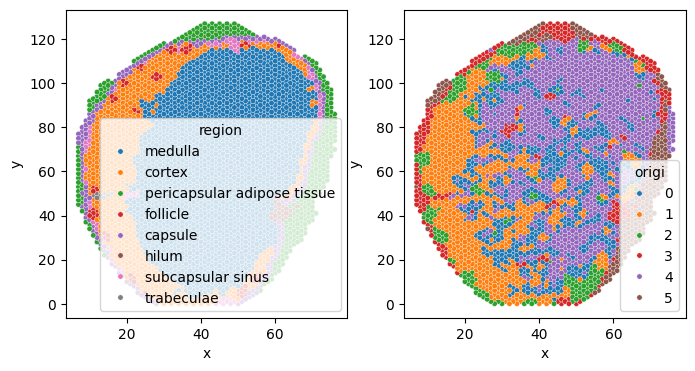

In [6]:
df_spatial = pd.DataFrame(adata.obsm['spatial'])
true_labels = pd.factorize(true_annotation['manual-anno'])[0]
df_spatial['region'] = true_annotation['manual-anno']
df_spatial['origi'] = pd.factorize(adata.obs['label_new'])[0]
df_spatial.columns = ['x', 'y', 'region', 'origi']
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 2, figsize=(8, 4))
# ax = sns.scatterplot(x="x", y="y", hue = 'region',s = 15,  data=df_spatial, palette="tab10")
sns.scatterplot(x="x", y="y", hue = 'region',s = 15,  data=df_spatial, palette="tab10", ax = axes[0])
sns.scatterplot(x="x", y="y", hue = 'origi',s = 15,  data=df_spatial, palette="tab10", ax = axes[1])
# ax.set_title("Human Lymph Node: Ground truth")
# ax.legend(loc='center right', bbox_to_anchor=(1.55, 0.5), ncol=1)
plt.show()

In [7]:
if np.min(true_labels) >= 0:
    n_clusters = len(np.unique(true_labels))
else:
    n_clusters = len(np.unique(true_labels)) - 1
n_clusters

8

## Data analysis

In [8]:
from sklearn.decomposition import PCA
# from GraphST.utils import refine_label
from sklearn.preprocessing import StandardScaler
# from GraphST.utils import mclust_R
import numpy as np
from numpy import dot, array
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

In [9]:
print(adjusted_rand_score(true_annotation['manual-anno'], adata.obs['SpatialGlue']))
print(normalized_mutual_info_score(true_annotation['manual-anno'], adata.obs['SpatialGlue']))

print(adjusted_rand_score(true_annotation['manual-anno'], adata.obs['totalVI']))
print(normalized_mutual_info_score(true_annotation['manual-anno'], adata.obs['totalVI']))

0.34306668778464056
0.4090097484436393
0.18610599588127033
0.32177329673795263


In [10]:
embedding = adata.obsm['RNA_feat']
n_neighbors = 3
connectivity = kneighbors_graph(adata.obsm['spatial'], n_neighbors=n_neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
embedding_RNA = connectivity.dot(embedding)

embedding = adata.obsm['Pro_feat']
connectivity = kneighbors_graph(adata.obsm['spatial'], n_neighbors=n_neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
embedding_Pro = connectivity.dot(embedding)

pca = PCA(n_components=2, random_state=42) 
RNA_pca_embedding = pca.fit_transform(embedding_RNA)

pca = PCA(n_components=2, random_state=42) 
Pro_pca_embedding = pca.fit_transform(embedding_Pro)

# Standardize the data
scaler_a = StandardScaler()
scaler_b = StandardScaler()

data_a_train = scaler_a.fit_transform(embedding_RNA)
data_b_train = scaler_b.fit_transform(embedding_Pro)

# Define and train the CCA model
n_components = 5  # Number of canonical components
cca = CCA(n_components=n_components)
cca.fit(data_a_train, data_b_train)

#adata.obsm['emb_pca'] = np.concatenate((embedding_RNA/np.linalg.norm(embedding_RNA), embedding_Pro), axis=1)

CCA(n_components=5)

In [11]:
### SOTA
n_clusters = 6
from sklearn.mixture import BayesianGaussianMixture
from mvlearn.datasets import load_UCImultifeature
from mvlearn.embed import GCCA
# gcca = GCCA(n_components = 20)
# Xs_latents = gcca.fit_transform(Xs)

from mvlearn.plotting import crossviews_plot
from mvlearn.embed import DCCA
from mvlearn.embed import MCCA
from mvlearn.embed import KMCCA

# Xs = [data_a_train, data_b_train] # multiview data
Xs = [data_a_train-data_a_train.min(), data_b_train-data_b_train.min()] # multiview data
# mcca = MCCA(n_components = 20, regs = 1)
mcca = KMCCA(n_components = 20, kernel = 'poly', regs = 0)
mcca.fit(Xs)
# MCCA()
Xs_latents = mcca.transform(Xs)
adata.obsm['emb_pca'] = np.concatenate((Xs_latents[0,:,:], Xs_latents[1,:,:]), axis=1)
gmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, init_params = 'random_from_data', n_init = 5, max_iter = 1000)
# gmm.means_init = np.array([embedding[initial_labels == i].mean(axis=0) for i in range(n_clusters)])
# Step 4: Fit GMM
gmm.fit(adata.obsm['emb_pca'])
cluster_labels = gmm.predict(adata.obsm['emb_pca'])
adata.obs['domain'] = cluster_labels
print(adjusted_rand_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))
print(normalized_mutual_info_score(true_labels[true_labels>=0], adata.obs['domain'][true_labels>=0]))
# 0.577826299329979
# 0.4273131900468386

0.577826299329979
0.4273131900468386
